In [2]:
#logic, view tensor as (-1,group_size) and do per channel quant
import torch
def quantize_tensor(tensor,dtype=torch.int8):
    r_max = tensor.max()
    r_min = tensor.min()
    tensor_dtype = tensor.dtype
    q_max = torch.iinfo(dtype).max
    q_min = torch.iinfo(dtype).min
    #scale must be in higher precision
    if q_max - q_min == 0:
        q_max += 1e-9
    scale = torch.tensor((r_max-r_min)/(q_max-q_min),dtype=tensor_dtype)
    zero = int(torch.round(q_min - (r_min/scale)))
    if zero > q_max:
        zero = q_max
    if zero < q_min:
        zero = q_min
    q_tensor = tensor/scale + zero
    rounded_tensor = torch.round(q_tensor)
    rounded_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)
    return rounded_tensor,scale,zero

In [3]:
def de_quantize(tensor,scale,zero,dtype=torch.float32):
    deq_tensor = scale * (tensor.float() - zero)
    return deq_tensor

In [5]:
def per_channel_quant(tensor,dim,dtype=torch.int8):
    output_dim = tensor.shape[dim]
    qs,scales,zeros = [],[],[]
    for index in range(output_dim):
        sub_tensor = tensor.select(dim,index)
        q,s,z = quantize_tensor(sub_tensor,dtype)
        qs.append(q)
        scales.append(s)
        zeros.append(z)
    qs = torch.stack(qs,dim)
    return qs,scales,zeros

In [6]:
def per_channel_de_quant(tensor,scales,zeros,dim,dtype=torch.float32):
    output_dim = tensor.shape[dim]
    de_qs = []
    for index in range(output_dim):
        sub_tensor = tensor.select(dim,index)
        de_q = de_quantize(sub_tensor,scales[index],zeros[index],dtype)
        de_qs.append(de_q)
    de_qs = torch.stack(de_qs,dim)
    return de_qs

In [40]:
def per_group_quant(tensor,group,dtype=torch.int8):
    t_shape = tensor.shape[1]
    assert t_shape % group == 0
    assert tensor.dim() == 2
    tensor = tensor.view(-1,group)
    qs,scales,zeros = per_channel_quant(tensor,dim=1)
    return qs,scales,zeros,tensor

In [133]:
group = 2
z = torch.randint(low=-600,high=600,size=(8,8)) + torch.randn((8,8))
q_z,scales,zeros,z_2 = per_group_quant(z,group,dtype=torch.int8)

/var/folders/xw/knd54pd91c7cw57n21dntvx80000gn/T/ipykernel_25318/1006895011.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor((r_max-r_min)/(q_max-q_min),dtype=tensor_dtype)


In [134]:
q_z

tensor([[ 122,   95],
        [-101,   72],
        [ 127,   65],
        [ -30,  -71],
        [ -42,   72],
        [  26,  125],
        [  22,  -46],
        [  69,  -39],
        [ -99, -128],
        [ -35,    3],
        [-128,  -89],
        [  77,   73],
        [ 107, -104],
        [ -66, -124],
        [  34,   72],
        [ -57,   88],
        [   7,  127],
        [ -94,  110],
        [-122, -107],
        [ 119, -108],
        [  -7,   95],
        [ 119,  -64],
        [ -69,   30],
        [  30,   13],
        [  73,   44],
        [  62,  -26],
        [ 101,   31],
        [-100,  -62],
        [ -12,   50],
        [ 101,  -92],
        [ -83,  -92],
        [  15,  -22]], dtype=torch.int8)

In [135]:
z_2

tensor([[ 577.6835,  268.4368],
        [-300.0744,  181.9255],
        [ 599.6863,  155.7089],
        [ -18.7181, -349.0427],
        [ -66.2393,  181.6251],
        [ 201.6528,  377.9402],
        [ 185.6853, -257.4726],
        [ 371.7248, -229.1153],
        [-290.7590, -560.4369],
        [ -40.7851,  -74.5612],
        [-404.5382, -416.3343],
        [ 403.4093,  185.5823],
        [ 519.7712, -472.4055],
        [-160.5051, -544.5574],
        [ 232.1003,  182.1959],
        [-124.2054,  240.6213],
        [ 126.4416,  385.4799],
        [-272.9518,  323.4535],
        [-380.9373, -481.7036],
        [ 565.1397, -487.1913],
        [  69.6775,  266.6592],
        [ 568.1028, -321.8268],
        [-173.8828,   26.1767],
        [ 216.5446,  -37.6865],
        [ 387.8299,   78.3883],
        [ 342.4038, -180.3087],
        [ 495.4989,   28.1435],
        [-293.5148, -314.8549],
        [  50.9673,   99.9262],
        [ 495.3262, -426.9879],
        [-229.7797, -426.5777],
        

In [136]:
def per_group_dequant(tensor,scales,zeros,dtype=torch.int8,shape=None):
    t_shape = tensor.shape[1]
    assert t_shape % group == 0
    assert tensor.dim() == 2
    tensor = tensor.view(-1,group)
    de_qs = per_channel_de_quant(tensor,scales,zeros,dim=1)
    return de_qs.view(shape)

In [137]:
de_qz = per_group_dequant(q_z,scales,zeros,torch.int8,z.shape)

In [138]:
err = abs(z-de_qz)

tensor(0.9321)

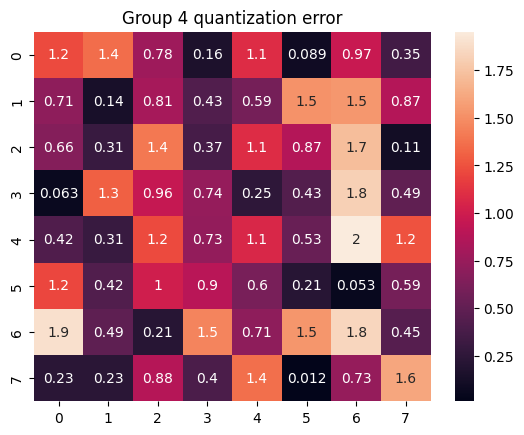

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(abs(z-de_qz),annot=True)
plt.title("Group 4 quantization error")
err = abs(z-de_qz)
torch.square(err).mean()

### per channel quant (for comparison)

### 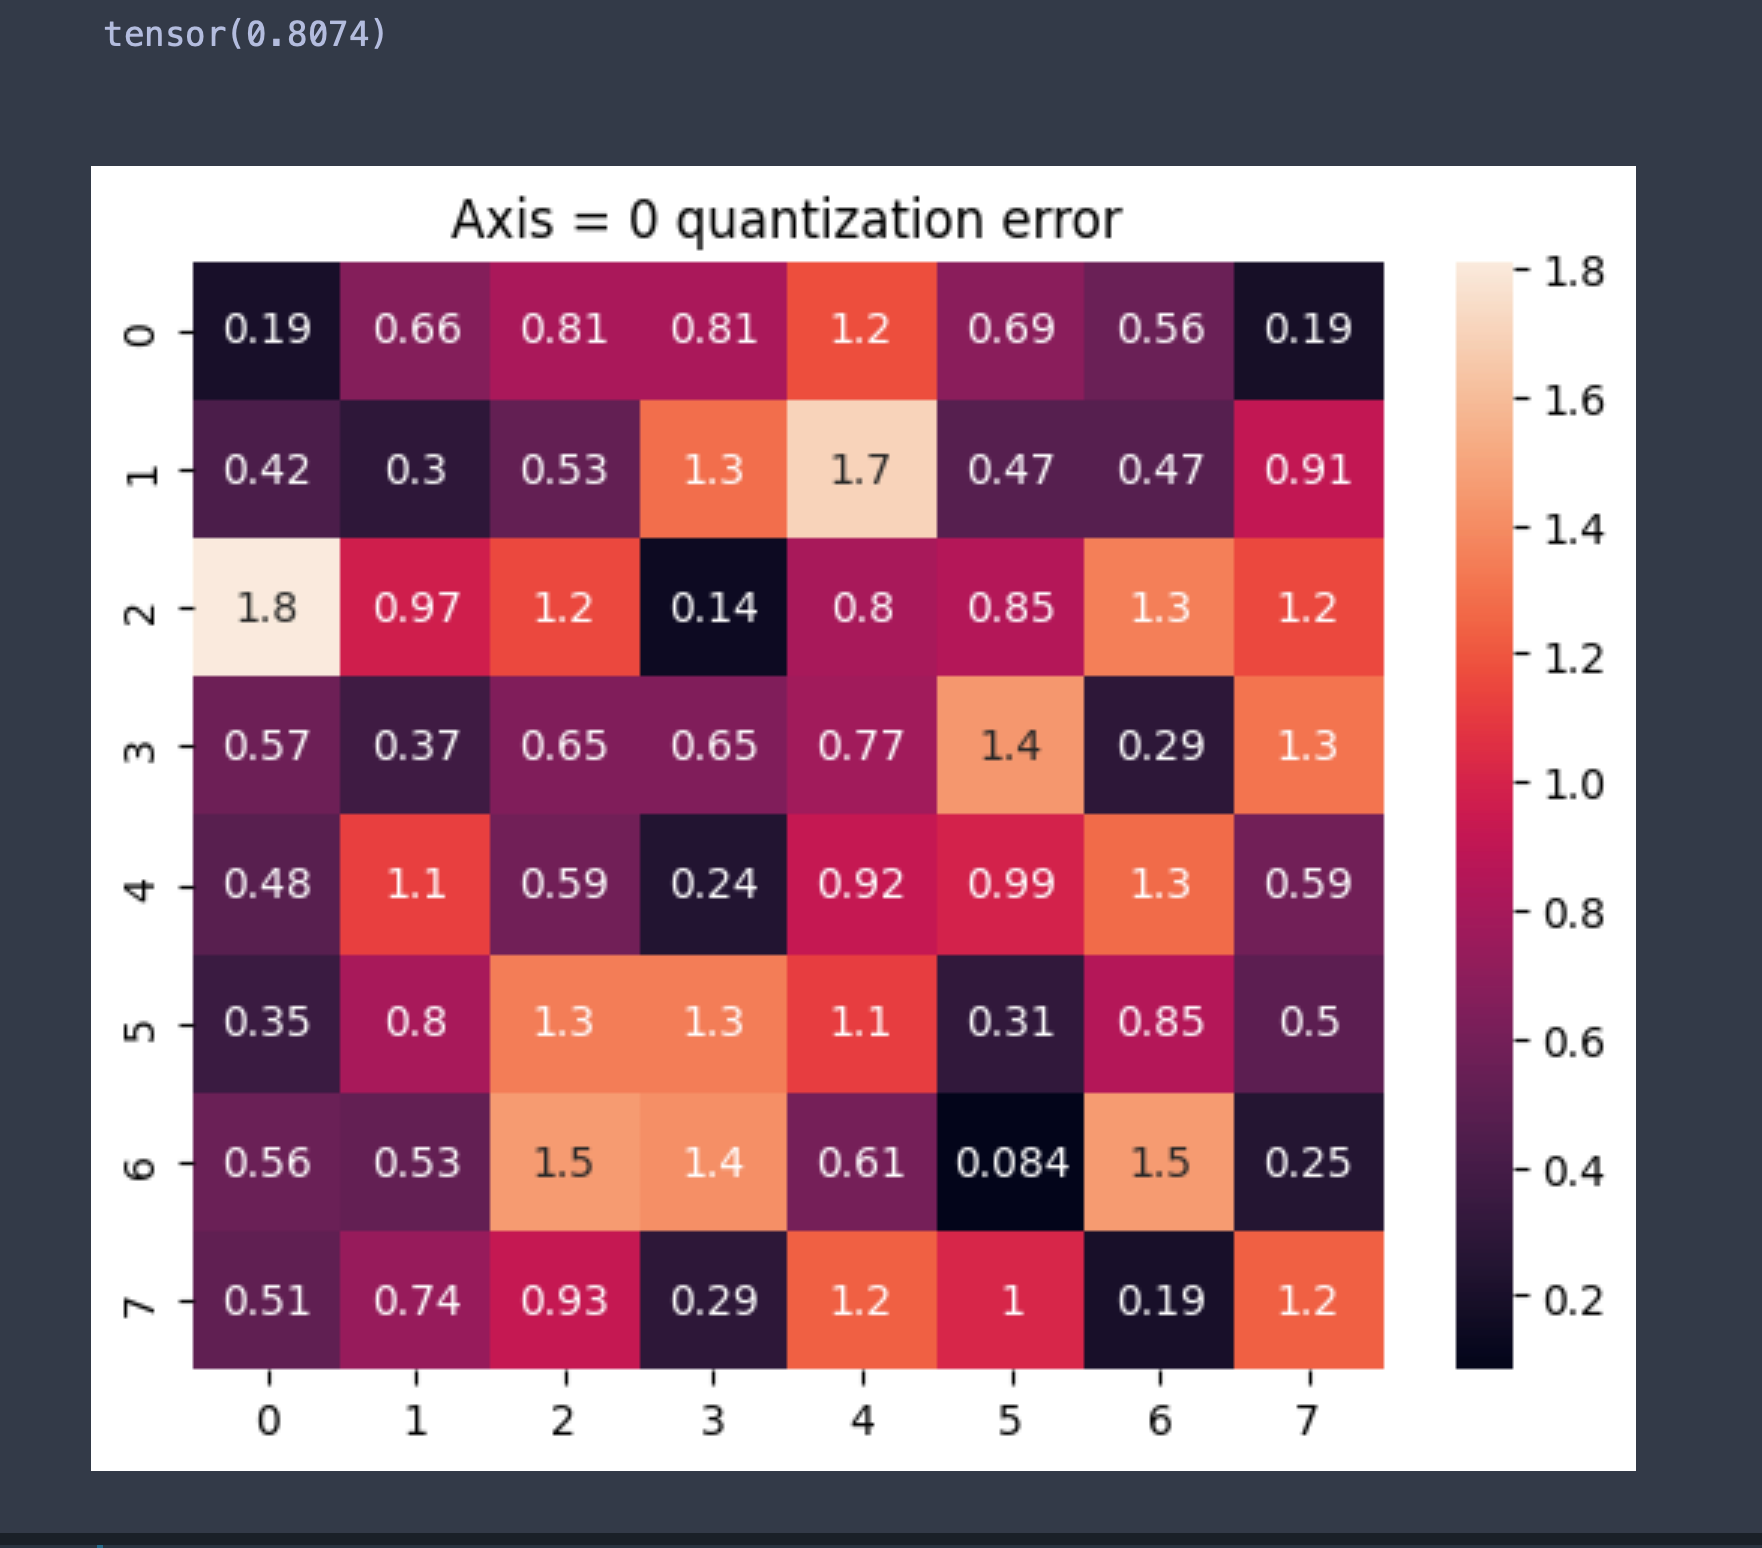

## 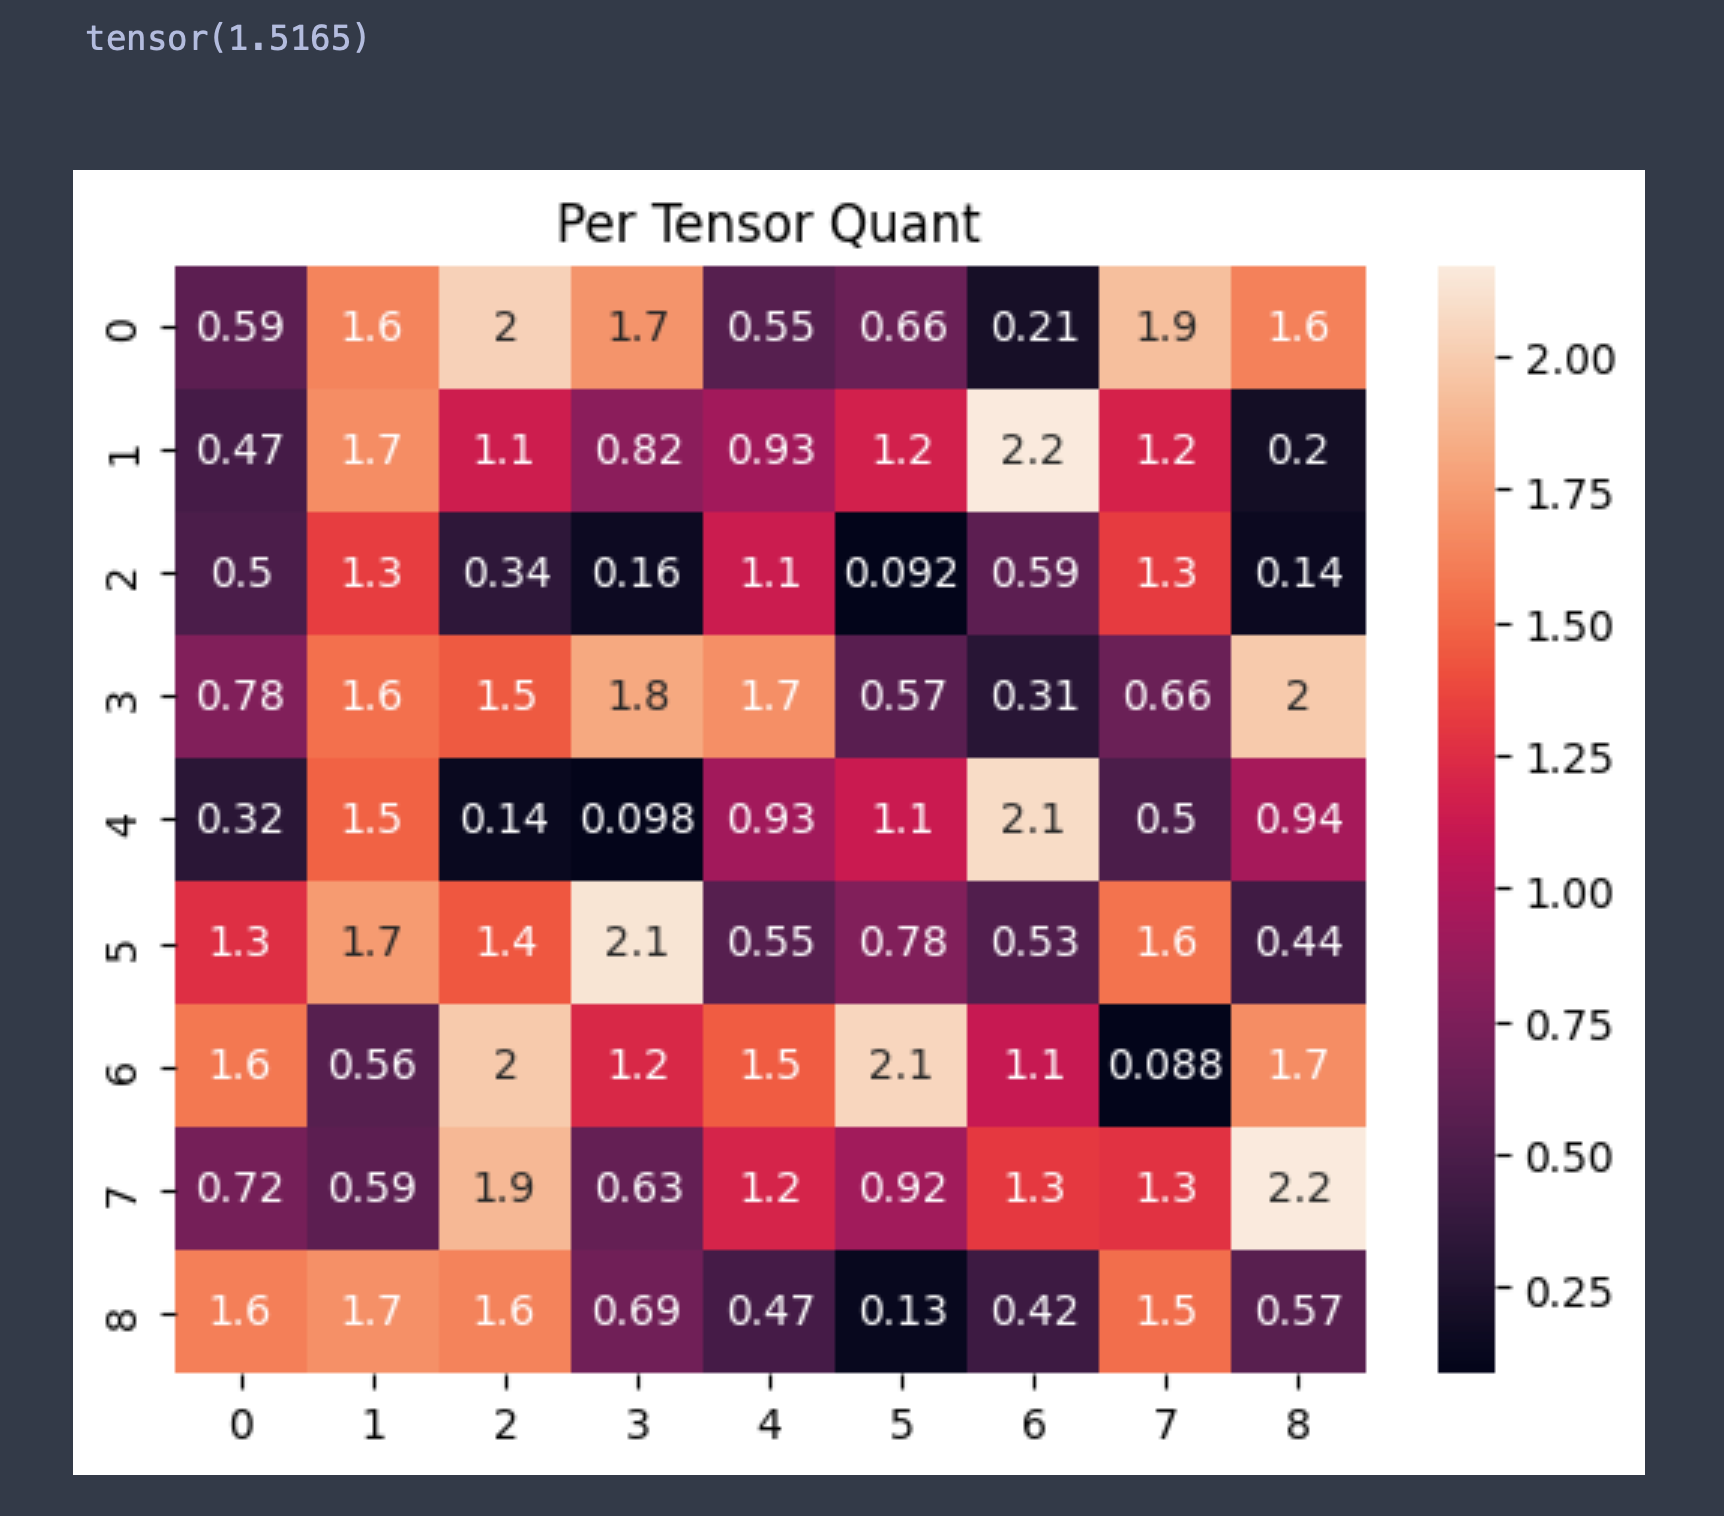